/tmp/ipykernel_32289/3450965177.py:83: RuntimeWarning: invalid value encountered in double_scalars
  approx_ratio = expectation / max_cost_diagonal
/tmp/ipykernel_32289/3450965177.py:104: RuntimeWarning: invalid value encountered in double_scalars
  approx_ratio = expectation / max_cost_diagonal


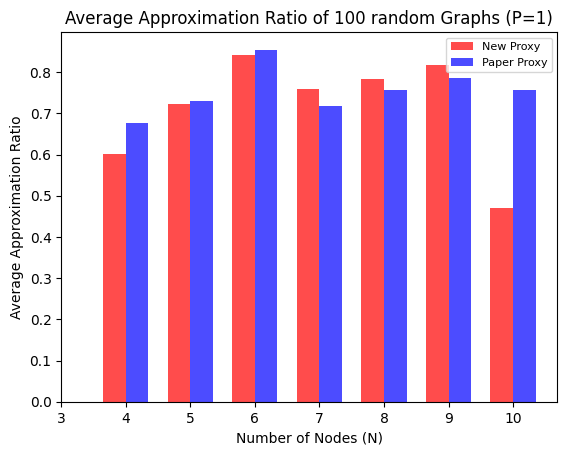

In [22]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import qokit.maxcut as mc
from QAOA_simulator import get_expectation, get_simulator
import QAOA_proxy as qp
import QAOA_paper_proxy as qpp
import os  #データ保存に必要

# QAOAの層数
p = 1

# 各Nの近似比率を格納するリスト（各Nに対して10回の平均を格納）
approx_ratios_new_proxy = []
approx_ratios_paper_proxy = []

# 保存先ディレクトリを指定
save_dir = "data_for_graphs_Approx_Raito"
os.makedirs(save_dir, exist_ok=True)  # ディレクトリが存在しない場合は作成する

def erdos_reyni(num_verts: int, num_edges: int, seed: int | None = None) -> nx.Graph:
    # num_verts: グラフの頂点の数
    # num_edges: グラフのエッジの数
    # seed: 乱数生成のシード（省略可能）

    # num_verts個の頂点を持つ完全グラフを生成します
    G = nx.complete_graph(num_verts)

    # 乱数シードが指定されていれば、そのシードで乱数を初期化します
    if (seed is not None):
        np.random.seed(seed)

    # 完全グラフのエッジのリストを取得し、NumPy配列に変換します
    edges = np.array(G.edges())

    # エッジのインデックスからnum_edges本のエッジを除去するためのランダムなインデックスを選択します
    indices = np.random.choice(a=len(edges), size=len(edges) - num_edges, replace=False)

    # 選択したインデックスのエッジをグラフから削除します
    for index in indices:
        G.remove_edge(edges[index][0], edges[index][1])

    # 最終的なグラフを返します
    return G

#試行回数
T = 100

# Nを5から10まで変化させて計算
for N in range(3, 11):

    for i in range(T):
        
        # 各Nについて10回の試行の近似比率を格納するリスト
        approx_ratios_new_proxy_i = []
        approx_ratios_paper_proxy_i = []


        # エルデシュ・レーニイグラフの生成（ノード数N、エッジの確率0.5）
        G = nx.erdos_renyi_graph(N, 0.5)

        # グラフからIsingモデルの項を取得
        ising_model = mc.get_maxcut_terms(G)

        # シミュレーターの初期化
        sim = get_simulator(N, ising_model)

        # 初期のgammaとbetaを設定（全て0.1）
        init_gamma, init_beta = np.full((2, p), 0.1)

        # QAOAプロキシを使ってQAOAの実行（結果としてgammaとbetaを取得）
        result = qp.QAOA_proxy_run(G.number_of_edges(), N, p, init_gamma, init_beta)
        gamma = result["gamma"]
        beta = result["beta"]

        # 得られたgammaとbetaで期待値を計算
        expectation = get_expectation(N, ising_model, gamma, beta)

        # シミュレーターからコスト対角成分の最大値を取得
        max_cost_diagonal = max(sim.get_cost_diagonal())

        # 近似比率（期待値/最大コスト対角成分）を計算
        approx_ratio = expectation / max_cost_diagonal

        # 結果をリストに追加
        approx_ratios_new_proxy_i.append(approx_ratio)

        np.save(f"data_for_graphs_Approx_Raito/data_for_approx_ratio_new_proxy_N={N}_G{i}.npy", approx_ratio)

        ############

        # QAOAプロキシ（論文版）を使ってQAOAの実行（結果としてgammaとbetaを取得）
        result = qpp.QAOA_paper_proxy_run(G.number_of_edges(), N, p, init_gamma, init_beta)
        gamma = result["gamma"]
        beta = result["beta"]

        # 得られたgammaとbetaで期待値を計算
        expectation = get_expectation(N, ising_model, gamma, beta)

        # シミュレーターからコスト対角成分の最大値を取得
        max_cost_diagonal = max(sim.get_cost_diagonal())

        # 近似比率（期待値/最大コスト対角成分）を計算
        approx_ratio = expectation / max_cost_diagonal

        # 結果をリストに追加
        approx_ratios_paper_proxy_i.append(approx_ratio)

        np.save(f"data_for_graphs_Approx_Raito/data_for_approx_ratio_paper_proxy_N={N}_G{i}.npy", approx_ratio)

        # 各Nに対して10回の試行の平均を計算
    approx_ratios_new_proxy.append(np.mean(approx_ratios_new_proxy_i))
    approx_ratios_paper_proxy.append(np.mean(approx_ratios_paper_proxy_i))

# 棒グラフの作成
bar_width = 0.35  # バーの幅
index = np.arange(3, 11)  # x軸のインデックス

# 新しいプロキシの棒グラフ
plt.bar(index - bar_width / 2, approx_ratios_new_proxy, bar_width, color='red', alpha=0.7, label='New Proxy')

# 論文プロキシの棒グラフ
plt.bar(index + bar_width / 2, approx_ratios_paper_proxy, bar_width, color='blue', alpha=0.7, label='Paper Proxy')

# グラフの設定
plt.xlabel('Number of Nodes (N)')
plt.ylabel('Average Approximation Ratio')
plt.title(f'Average Approximation Ratio of {T} random Graphs (P={p})')
plt.xticks(index)  # x軸の目盛りを設定
plt.legend(prop={'size': 8})

# グラフの表示
plt.show()


p=5についても同様なグラフを作成したい。（時間がかかるので、GPUを使用する）

--------------
I would like to create a similar graph for p=5 as well. (Since it takes time, I will use a GPU.)


In [23]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import qokit.maxcut as mc
from QAOA_simulator import get_expectation, get_simulator
import QAOA_proxy as qp
import QAOA_paper_proxy as qpp
import os  #データ保存に必要

# QAOAの層数
p = 5

# 各Nの近似比率を格納するリスト（各Nに対して10回の平均を格納）
approx_ratios_new_proxy = []
approx_ratios_paper_proxy = []

# 保存先ディレクトリを指定
save_dir = "data_for_graphs_Approx_Raito(P=5)"
os.makedirs(save_dir, exist_ok=True)  # ディレクトリが存在しない場合は作成する

def erdos_reyni(num_verts: int, num_edges: int, seed: int | None = None) -> nx.Graph:
    # num_verts: グラフの頂点の数
    # num_edges: グラフのエッジの数
    # seed: 乱数生成のシード（省略可能）

    # num_verts個の頂点を持つ完全グラフを生成します
    G = nx.complete_graph(num_verts)

    # 乱数シードが指定されていれば、そのシードで乱数を初期化します
    if (seed is not None):
        np.random.seed(seed)

    # 完全グラフのエッジのリストを取得し、NumPy配列に変換します
    edges = np.array(G.edges())

    # エッジのインデックスからnum_edges本のエッジを除去するためのランダムなインデックスを選択します
    indices = np.random.choice(a=len(edges), size=len(edges) - num_edges, replace=False)

    # 選択したインデックスのエッジをグラフから削除します
    for index in indices:
        G.remove_edge(edges[index][0], edges[index][1])

    # 最終的なグラフを返します
    return G

#試行回数
T = 100

# Nを5から10まで変化させて計算
for N in range(3, 11):

    for i in range(T):
        
        # 各Nについて10回の試行の近似比率を格納するリスト
        approx_ratios_new_proxy_i = []
        approx_ratios_paper_proxy_i = []


        # エルデシュ・レーニイグラフの生成（ノード数N、エッジの確率0.5）
        G = nx.erdos_renyi_graph(N, 0.5)

        # グラフからIsingモデルの項を取得
        ising_model = mc.get_maxcut_terms(G)

        # シミュレーターの初期化
        sim = get_simulator(N, ising_model)

        # 初期のgammaとbetaを設定（全て0.1）
        init_gamma, init_beta = np.full((2, p), 0.1)

        # QAOAプロキシを使ってQAOAの実行（結果としてgammaとbetaを取得）
        result = qp.QAOA_proxy_run(G.number_of_edges(), N, p, init_gamma, init_beta)
        gamma = result["gamma"]
        beta = result["beta"]

        # 得られたgammaとbetaで期待値を計算
        expectation = get_expectation(N, ising_model, gamma, beta)

        # シミュレーターからコスト対角成分の最大値を取得
        max_cost_diagonal = max(sim.get_cost_diagonal())

        # 近似比率（期待値/最大コスト対角成分）を計算
        approx_ratio = expectation / max_cost_diagonal

        # 結果をリストに追加
        approx_ratios_new_proxy_i.append(approx_ratio)

        np.save(f"data_for_graphs_Approx_Raito(P=5)/data_for_approx_ratio_new_proxy_N={N}_G{i}.npy", approx_ratio)

        ############

        # QAOAプロキシ（論文版）を使ってQAOAの実行（結果としてgammaとbetaを取得）
        result = qpp.QAOA_paper_proxy_run(G.number_of_edges(), N, p, init_gamma, init_beta)
        gamma = result["gamma"]
        beta = result["beta"]

        # 得られたgammaとbetaで期待値を計算
        expectation = get_expectation(N, ising_model, gamma, beta)

        # シミュレーターからコスト対角成分の最大値を取得
        max_cost_diagonal = max(sim.get_cost_diagonal())

        # 近似比率（期待値/最大コスト対角成分）を計算
        approx_ratio = expectation / max_cost_diagonal

        # 結果をリストに追加
        approx_ratios_paper_proxy_i.append(approx_ratio)

        np.save(f"data_for_graphs_Approx_Raito(P=5)/data_for_approx_ratio_paper_proxy_N={N}_G{i}.npy", approx_ratio)

        # 各Nに対して10回の試行の平均を計算
    approx_ratios_new_proxy.append(np.mean(approx_ratios_new_proxy_i))
    approx_ratios_paper_proxy.append(np.mean(approx_ratios_paper_proxy_i))

# 棒グラフの作成
bar_width = 0.35  # バーの幅
index = np.arange(3, 11)  # x軸のインデックス

# 新しいプロキシの棒グラフ
plt.bar(index - bar_width / 2, approx_ratios_new_proxy, bar_width, color='red', alpha=0.7, label='New Proxy')

# 論文プロキシの棒グラフ
plt.bar(index + bar_width / 2, approx_ratios_paper_proxy, bar_width, color='blue', alpha=0.7, label='Paper Proxy')

# グラフの設定
plt.xlabel('Number of Nodes (N)')
plt.ylabel('Average Approximation Ratio')
plt.title(f'Average Approximation Ratio of {T} random Graphs (P={p})')
plt.xticks(index)  # x軸の目盛りを設定
plt.legend(prop={'size': 8})

# グラフの表示
plt.show()

/tmp/ipykernel_32289/3138794040.py:83: RuntimeWarning: invalid value encountered in double_scalars
  approx_ratio = expectation / max_cost_diagonal
/tmp/ipykernel_32289/3138794040.py:104: RuntimeWarning: invalid value encountered in double_scalars
  approx_ratio = expectation / max_cost_diagonal


KeyboardInterrupt: 

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.
